# Machine Learning for Textual Data - Donald Trump's Tweets
<b> Advanced Numberical Methods and Data Analysis - University of St. Gallen (HSG) - Spring semester 2019 </b>

Elisa Fleissner       (14-350-608)

Lars Stauffenegger    (tbd)

Alexander Steeb       (tbd)

07.05.2019

--------------------------------------------------------------------------------------------

# Project plan
Two models: Word count/frequency (LDA) and word2vec


In [1]:
import sys
print(sys.executable)
print(sys.version)

/usr/local/Cellar/python/3.7.2_2/bin/python3.7
3.7.2 (default, Feb 12 2019, 08:15:36) 
[Clang 10.0.0 (clang-1000.11.45.5)]


## 0. Setup

In [2]:
# import functions
import json
import os
import pandas as pd

import re

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexandersteeb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Data import

Source:
https://sites.google.com/site/ruwach/bibletext

In [433]:
import requests, zipfile, io
#old_zip_file_url = "https://sites.google.com/site/ruwach/Basic_English_OldTestament.zip?attredirects=0"

old_zip_file_url = "http://ruwach.googlepages.com/OldTestament.zip"

#new_zip_file_url = "https://sites.google.com/site/ruwach/Basic_English_NewTestament.zip?attredirects=0"
new_zip_file_url = "http://ruwach.googlepages.com/NewTestament.zip"
    
def unzip(url):
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("data/")
    
unzip(old_zip_file_url)
unzip(new_zip_file_url)

In [434]:
path = "data"
df = pd.DataFrame()  


testaments = os.listdir(path)

for testament in testaments:
    testament_path = os.path.join(path,testament)
    books = os.listdir(testament_path)
    print(testament)
    
    for book in books:
        book_path = os.path.join(testament_path,book)
        files = os.listdir(book_path)    
            
        for file in files:
            file_path = os.path.join(book_path,file) 
            
            with open(file_path,"r", encoding="utf-8") as infile:
                text = infile.read()
                df = df.append([[text, testament, book, file, file_path]], ignore_index=True)
                
df.columns = ["text", "testament", "book", "file", "path"]



OldTestament
NewTestament


In [435]:
books = (
    "Genesis",
    "Exodus",
    "Leviticus",
    "Numbers",
    "Deuteronomy",
    "Joshua",
    "Judges",
    "Ruth",
    "1 Samuel",
    "2 Samuel",
    "1 Kings",
    "2 Kings",
    "1 Chronicles",
    "2 Chronicles",
    "Ezra",
    "Nehemiah",
    "Esther",
    "Job",
    "Psalms",
    "Proverbs",
    "Ecclesiastes",
    "Song of Solomon",
    "Isaiah",
    "Jeremiah",
    "Lamentations",
    "Ezekiel",
    "Daniel",
    "Hosea",
    "Joel",
    "Amos",
    "Obadiah",
    "Jonah",
    "Micah",
    "Nahum",
    "Habbakuk",
    "Zephaniah",
    "Haggai",
    "Zechariah",
    "Malachi",
    "Matthew",
    "Mark",
    "Luke",
    "John",
    "Acts",
    "Romans",
    "1 Corinthians",
    "2 Corinthians",
    "Galatians",
    "Ephesians",
    "Philippians",
    "Colossians",
    "1 Thessalonians",
    "2 Thessalonians",
    "1 Timothy",
    "2 Timothy",
    "Titus",
    "Philemon",
    "Hebrews",
    "James",
    "1-2 Peter",
    "1-3 John",
    "Jude",
    "Revalation")


In [436]:
books_order = pd.DataFrame.from_records(zip(books, range(1,len(books))))

books_order.columns = ["book", "order"]

df = pd.merge(df,books_order, on='book')

In [437]:
df = df.sort_values(["order","file"], ascending=[True,True])
df.reset_index(drop=True, inplace=True)

## 2. Data cleaning

Data cleaning: Stemming, tokenization, see other documentation
Data visualisation (eg wordcloud)
Data inspection

In [471]:
def preprocessor(text):
    '''removing all punctuation, non-letter characters and white spaces'''
    text.strip()
    text = (re.sub('[\W]+', ' ', text.lower()))      #remove non-word characters and make text lowercase
    text = (re.sub('[\d]+', '', text))               #to remove numbers [0-9]
    text = (re.sub('\n', ' ', text))

    return text.strip()

def tokenizer(text):
    '''split text into single words and return a list of these words'''
    return text.split()

def remove_stopwords(text):
    stop = stopwords.words('english')
    words = [word for word in text.split()]
    stopremoved = [w for w in words if w not in stop]
    return ' '.join(stopremoved)

def tokenizer_porter(text):
    '''Porter stemmer - split text and convert all words back to 
    their stem, e.g. running -> run, return a list of the stemmed words'''
    
    stop = stopwords.words('english')
    porter = PorterStemmer()
    
    stopremoved = [w for w in text.split() if w not in stop] #removing common stop words as downloaded from nltk package
    stem = [porter.stem(word) for word in stopremoved]

    return " ".join(stem)

In [439]:
pd.set_option('display.max_colwidth', -1)
#df.head()

In [440]:
#apply preprocessor for Wordcloud and merge all preprocessed speeches to one text
wordcloud_df = df['text'].apply(preprocessor)
wordcloud_df = wordcloud_df.apply(remove_stopwords)

full_text = ''
for text in wordcloud_df:
    full_text += text

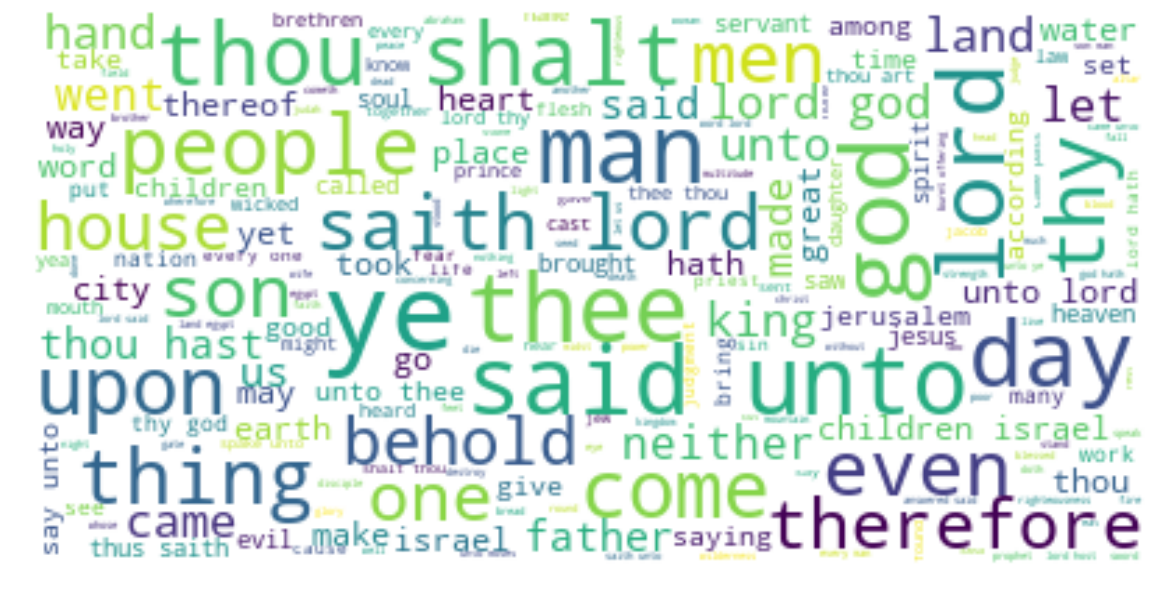

In [441]:
# generate word cloud 
wordcloud = WordCloud(max_font_size=40,background_color="white").generate(full_text)

# display
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 3. Model 1 - LDA

see documentation - Elisa 

In [472]:
# apply preprocessor for LDA

# apply preprocessor to speeches in data frame
df['cleaned'] = df['text']
df['cleaned'] = df['cleaned'].apply(preprocessor)

#Processing documents into tokens (incl. stemming and removing stopwords)
df['cleaned'] = df['cleaned'].apply(tokenizer_porter)

In [473]:
df['cleaned']

0      begin god creat heaven earth earth without form void dark upon face deep spirit god move upon face water god said let light light god saw light good god divid light dark god call light day dark call night even morn first day god said let firmament midst water let divid water water god made firmament divid water firmament water firmament god call firmament heaven even morn second day god said let water heaven gather togeth unto one place let dri land appear god call dri land earth gather togeth water call sea god saw good god said let earth bring forth grass herb yield seed fruit tree yield fruit kind whose seed upon earth earth brought forth grass herb yield seed kind tree yield fruit whose seed kind god saw good even morn third day god said let light firmament heaven divid day night let sign season day year let light firmament heaven give light upon earth god made two great light greater light rule day lesser light rule night made star also god set firmament heaven give light u

In [508]:
n_components = 10

#Transformation Into Feature Vectors that count how often words appear in different speeches
count = CountVectorizer(
            max_df=0.9,
            min_df=2,
            max_features=100_000,
            ngram_range=(1,2)
            )

#for testament in testaments:
#    text = df.loc[df['testament'] == testament,"cleaned"]
text = df.loc[:,"cleaned"]
X = count.fit_transform(text)  #sparse matrix

#fit LDA 
lda = LatentDirichletAllocation(n_components=n_components, random_state=1000, learning_method='batch')

nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5)


X_topics = lda.fit_transform(X)
#X_topics = nmf.fit_transform(X)

lda.components_.shape
#print 5 most important words of every topic
print(testament)
print("The five most important words of three topics are:")
print()
n_top_words = 10
feature_names = count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i]
    for i in topic.argsort()\
        [:-n_top_words - 1:-1]]))
print()
print()

NewTestament
The five most important words of three topics are:

Topic 1:
ye shall said god jesu man say thou thing one
Topic 2:
shall lord upon hath man come thi day god ye
Topic 3:
shall lord offer ye upon israel day priest mose say
Topic 4:
lord thou shall thi thee god ye land peopl upon
Topic 5:
children god king day lord thou hundr let israel peopl
Topic 6:
children israel king shall citi famili tribe children israel son joshua
Topic 7:
king thereof daniel made thee shall kingdom prais gold thou
Topic 8:
thi thou thee lord shalt thou shalt lord thi thi god god shall
Topic 9:
said son said unto came thee father thi went thou land
Topic 10:
one pharaoh offer cubit year thereof shekel mose son five




In [509]:
X

<943x39765 sparse matrix of type '<class 'numpy.int64'>'
	with 289026 stored elements in Compressed Sparse Row format>

In [510]:
#for topic 1 to 5
print('Presidents in order of gving most weight to the specific topics')

titles = ['1', '2', '3',"4","5"]

for no in range(n_components):
    topic = X_topics[:, no].argsort()[::-1]  #sort in descending order and return index 
    print()
    print("Topic", titles[no])
    print('-'*40)
    presi = []
    for speech in topic:
        presi.append(df['book'][speech])
        if len(set(presi)) == 3: #make sure we only pick the 3 top presidents who belong in topic the most
            break 
            
    #Keep order in list but remove duplicates
    output = []
    seen = set()
    for p in presi:
        # If value has not been encountered yet, add it to both list and set.
        if p not in seen:
            output.append(p)
            seen.add(p)

    for p in output:
        print(p)

Presidents in order of gving most weight to the specific topics

Topic 1
----------------------------------------
Matthew
Mark
John

Topic 2
----------------------------------------
Daniel
Ezekiel
Isaiah

Topic 3
----------------------------------------
Leviticus
Exodus
Numbers

Topic 4
----------------------------------------
Jeremiah
Deuteronomy
Isaiah

Topic 5
----------------------------------------
Nehemiah
Ezra
Exodus



IndexError: list index out of range

IndexError: list index out of range

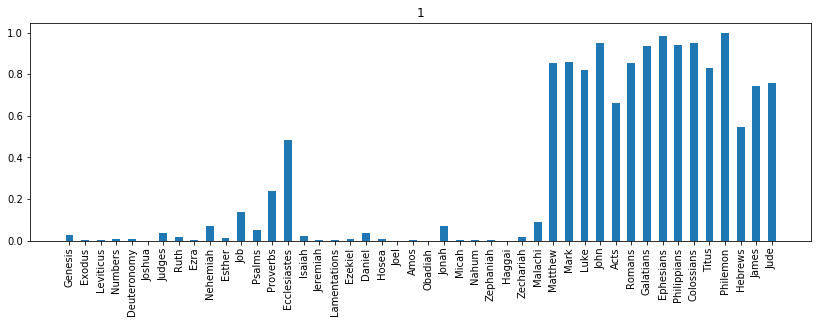

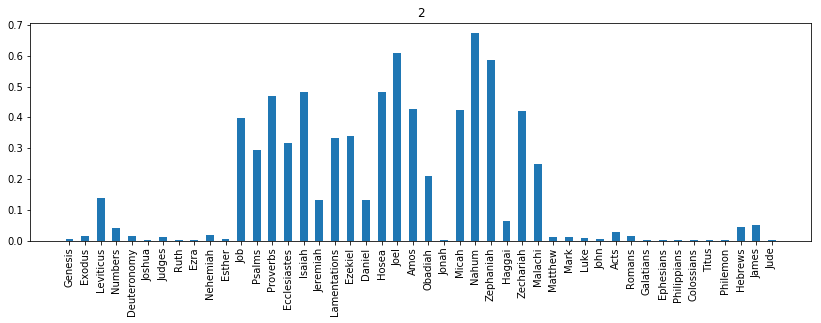

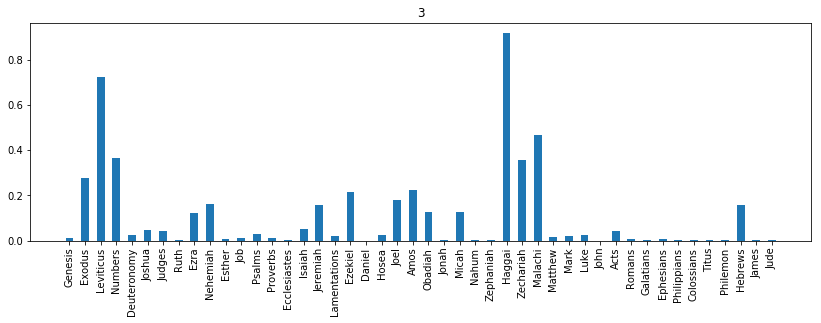

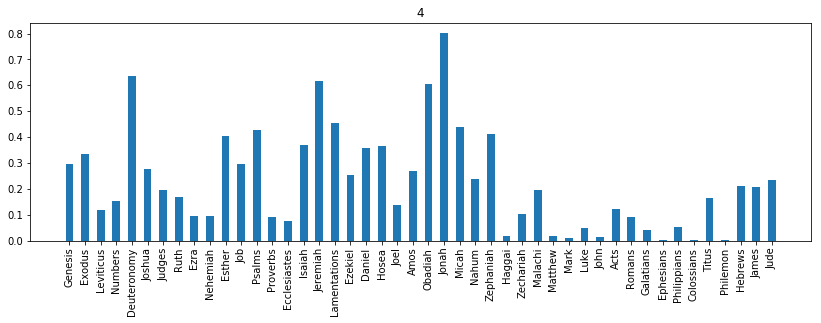

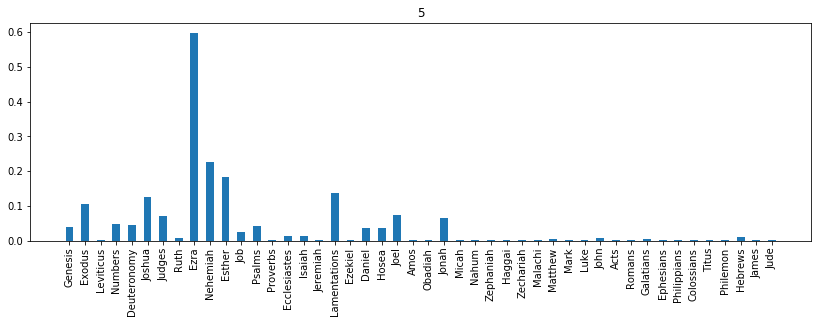

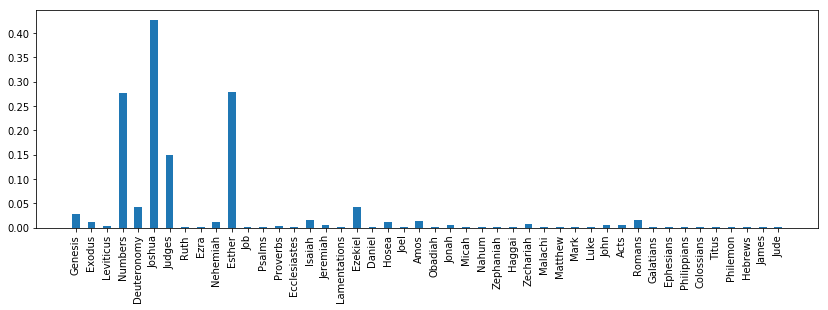

In [511]:
pset = set()  #set of all presidents
plist = []
for p in df['book']:
    if p not in pset:
        plist.append(p)
        pset.add(p)

weights=[]  #take the average over all speeches per president
for p in plist:
    line=[]
    indices = df.index[df['book'] == p]
    for i in indices:
        line.append(list(X_topics[i]))
    weights.append(list(np.mean(line, axis=0)))

#prepare plot - inspiration and code examples from https://de.dariah.eu/tatom/topic_model_visualization.html
N, K = len(weights), len(weights[0])
ind = np.arange(N)
width = 0.5 

#Plot for every single topic

for x in range(K):
    t = [] # alist with values for all 42 presidents for topic 1
    for entry in weights:
        t.append(entry[x])
    fig = plt.figure(figsize=(14,4))
    plt.bar(ind, t, width=width)
    plt.xticks(rotation=90)
    plt.xticks(ind , plist)
    plt.title(titles[x])

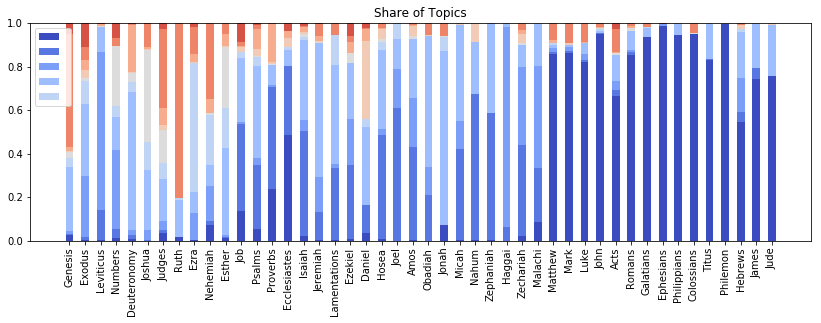

In [512]:
# #Stacked Bar plot
#prepare plot - inspiration and code examples from https://de.dariah.eu/tatom/topic_model_visualization.html
N, K = len(weights), len(weights[0])
ind = np.arange(N)
width = 0.5 
plots = []
height_cumulative = np.zeros(N)

s = []
for x in range(K):
    t = [] # alist with values for all 42 presidents for topic 1
    for entry in weights:
        t.append(entry[x])
    s.append(t)  #a list with 5 list, each with the weights on the respective topic per president
    
fig = plt.figure(figsize=(14,4))
for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, s[k], width, color=color)
    else:
        p = plt.bar(ind, s[k], width, bottom=height_cumulative, color=color)
    height_cumulative += s[k]
    plots.append(p)

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.title('Share of Topics')
plt.xticks(rotation=90)
plt.xticks(ind , plist)
  
for i in range(len(titles)):
    titles[i] = titles[i][15:]

plt.legend(titles,loc=2)
print()

## 4. Model 2 - Word2vec

on hold - Alex

Source:
https://nbviewer.jupyter.org/github/danielfrg/word2vec/blob/master/examples/word2vec.ipynb

In [567]:
len(str(df['text'].values).split())

611600

In [452]:
import word2vec

In [602]:
print(testaments[0])
with open("text_old.txt", "w") as text_file:
    text_file.write(str(df.loc[df['testament'] == testaments[0],'cleaned'].values))

print(testaments[1])
with open("text_new.txt", "w") as text_file:
    text_file.write(str(df.loc[df['testament'] == testaments[1],'cleaned'].values))

OldTestament
NewTestament


In [621]:
def estimate_word2vec(file):
    word2vec.word2phrase(train = file, 
                     output="text-phrases", 
                     min_count=1,
                     verbose=True)
    word2vec.word2vec("text-phrases", "text.bin", 
                  size=50, 
                  min_count=1,
#                  sample=1e-5, # Downsample high frequenzy words
                  verbose=True)
    return(word2vec.load('text.bin'))

In [585]:
## Predictions

In [622]:
print("Fit old testament model")
model_old = estimate_word2vec('text_old.txt')
print()
print("Fit new testament model")
model_new = estimate_word2vec('text_new.txt')

Fit old testament model
Starting training using file text_old.txt
Words processed: 200K     Vocab size: 106K  
Vocab size (unigrams + bigrams): 117809
Words in train file: 227663
Starting training using file text-phrases
Vocab size: 10064
Words in train file: 214680
Alpha: 0.002241  Progress: 91.98%  Words/thread/sec: 402.15k  
Fit new testament model
Starting training using file text_new.txt

Vocab size (unigrams + bigrams): 44036
Words in train file: 63730
Starting training using file text-phrases
Vocab size: 4784
Words in train file: 60564


In [623]:
indexes, metrics = model_old.similar("men")
model_old.generate_response(indexes, metrics).tolist()

[('saw', 0.9625457934830444),
 ('treacher_sister', 0.9624812635022649),
 ('river_chebar', 0.9607261690050984),
 ('appoint_weapon', 0.958486206821667),
 ('pursuer', 0.9507737317206351),
 ('fought', 0.949559373333062),
 ('fame', 0.9480184480071525),
 ('janohah', 0.9450922655307856),
 ('uzziah', 0.9439472412301294),
 ('og', 0.9427172624193088)]

In [624]:
indexes, metrics = model_new.similar("men")
model_new.generate_response(indexes, metrics).tolist()

[('much', 0.999641893748952),
 ('fall', 0.999604049625256),
 ('fill', 0.9995795556517929),
 ('preach', 0.999543944879989),
 ('therein', 0.9994660417987158),
 ('throughout', 0.9994520262381812),
 ('heavenli', 0.9994355620283314),
 ('lest', 0.9994260274854744),
 ('blood', 0.9994236719465714),
 ('better', 0.9994152904119634)]

## 5. Results